In [191]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql import functions as F

Primero se inicializa la SparkSession

Nota: Primero probare sin modificar la configuración inicial y ya si es necesario lo revisare en este link
https://spark.apache.org/docs/latest/configuration.html


In [2]:
ss = (SparkSession.builder.appName("ejercicio_pyspark").getOrCreate())

In [8]:
data = ss.read.csv('profeco/all_data.csv', header='true') ## 11.6GB de información

## Procesamiento de los datos

### ¿Cuántos registros hay?

In [9]:
print(data.count())

35275384


### ¿Cuántas categorías?

In [10]:
data.columns

['producto',
 'presentacion',
 'marca',
 'categoria',
 'catalogo',
 'precio',
 'fechaRegistro',
 'cadenaComercial',
 'giro',
 'nombreComercial',
 'direccion',
 'estado',
 'municipio',
 'latitud',
 'longitud']

In [16]:
data.select(F.countDistinct("categoria")).show()

+-------------------------+
|count(DISTINCT categoria)|
+-------------------------+
|                       40|
+-------------------------+



### ¿Cuántas cadenas comerciales están siendo monitoreadas?

In [17]:
data.select(F.countDistinct("cadenaComercial")).show()

+-------------------------------+
|count(DISTINCT cadenaComercial)|
+-------------------------------+
|                            606|
+-------------------------------+



### ¿Cómo podrías determinar la calidad de los datos? ¿Detectaste algún tipo de inconsistencia o error en la fuente?

Pues sería útil que en la fuente indicaran el número de datos que debería haber en la base de datos, las columnas con su tipo de dato y descripción. 
Sobre incosistencia se me  hizo raro que cuando extraje el archivo zip solo se descargaron 11.6 GB sin embargo cuando te metes al archivo zip dice la tabla pesa 20.7 GB. No se que ocurrió

### Cuáles son los productos más monitoreados en cada entidad?

In [43]:
conteo_estado_prod = data.groupBy(['estado', 'producto']).count()

In [83]:
conteo_max = conteo_estado_prod.groupBy('estado').agg(F.max(conteo_estado_prod['count']).alias('max_count')).withColumnRenamed('estado', 'estado_')

In [86]:
prod_top_entidad = (conteo_estado_prod.join(conteo_max,(F.col('estado') == F.col('estado_')) & (F.col('count') == F.col('max_count')))
                    .drop('estado_').drop('max_count'))  

In [88]:
prod_top_entidad.show()

+--------------------+--------------------+------+--------------------+---------+
|              estado|            producto| count|             estado_|max_count|
+--------------------+--------------------+------+--------------------+---------+
|COAHUILA DE ZARAGOZA|   DETERGENTE P/ROPA|  8272|COAHUILA DE ZARAGOZA|     8272|
|              COLIMA|   DETERGENTE P/ROPA| 11557|              COLIMA|    11557|
|              PUEBLA|            REFRESCO| 19151|              PUEBLA|    19151|
|        QUINTANA ROO|           LAVADORAS| 14730|        QUINTANA ROO|    14730|
|             SINALOA|   DETERGENTE P/ROPA| 19312|             SINALOA|    19312|
|            TLAXCALA|   DETERGENTE P/ROPA| 33021|            TLAXCALA|    33021|
|      AGUASCALIENTES|   DETERGENTE P/ROPA|  4074|      AGUASCALIENTES|     4074|
|             TABASCO|   DETERGENTE P/ROPA| 17385|             TABASCO|    17385|
|              OAXACA|LECHE ULTRAPASTEU...| 12316|              OAXACA|    12316|
|           QUER

### ¿Cuál es la cadena comercial con mayor variedad de productos monitoreados?

In [92]:
(data.groupby('cadenaComercial').agg(F.countDistinct('producto').alias('productos_distintos'))
 .sort(F.col("productos_distintos").desc()).head(1))

[Row(cadenaComercial='SORIANA', productos_distintos=1037)]

## Análisis exploratorio

### Genera una canasta de productos básicos que te permita comparar los precios geográfica y temporalmente

In [110]:
data.select('producto').distinct().rdd.map(lambda r: r[0]).collect()

['CHICHAROS EN LATA',
 'RADIOGRABADORAS',
 'MUCOSOLVAN',
 'ADVIL',
 'VARIOS',
 'VIDEOJUEGOS',
 'SUPRADOL',
 'LUTORAL',
 'GEODON IM',
 'LANOXIN',
 'GYNOVIN',
 'GARAMICINA',
 'KAOMYCIN',
 'SURIMI',
 'PETO',
 'LIBRO DE TEXTO DE CIVISMO',
 'PIERNA',
 'KIR. LUNCH',
 'ELECTROLIT. SUERO REHIDRATANTE',
 'AFUMIX',
 'BEDOYECTA',
 'MICARDIS PLUS',
 'TYLEX 750',
 'VERMOX PLUS',
 'MELOXICAM METOCARBAMOL',
 'CHOCO KRISPIS',
 'PRAVASTATINA',
 'FRIJOLES',
 'SPECIAL K',
 'SAN RAFAEL. REAL',
 'POSIPEN',
 'POLVO PARA BEBIDAS SABOR CHOCOLATE',
 'CARNE MOLIDA DE RES',
 'ACEITUNA. GORDAL',
 'CLARITYNE',
 'PARACETAMOL',
 'GARBANZA',
 'ZENTEL',
 'PAMPANILLO',
 'FOLDERS',
 'CHILES LARGOS EN ESCABECHE',
 'LISINOPRIL',
 'CAFE TOSTADO Y MOLIDO',
 'GELATINA EN POLVO',
 'CHOCOLATE EN TABLILLAS',
 'NOCHE BUENA CHALET',
 'DETERGENTE P/ROPA Y TRASTES',
 'PEDIALYTE. ELECTROLITOS ORALES',
 'MYCOSPOR',
 'COMPAS',
 'BLOCK',
 'CUADERNO FORMA COLLEGE',
 'ELATEC',
 'KLARICYD 12 H',
 'DICLOFENACO',
 'COMPLEJO B/ DEXAMETASONA,

De la lista anterior tomamos como canasta básica los productos: FRIJOLES, HUEVO y ARROZ. Compararemos el precio promedio de estos productos por estado. 

In [111]:
canasta_basica = ['FRIJOLES', 'HUEVO', 'ARROZ']

In [121]:
pregunta_1 = (data.filter(data.producto.isin(canasta_basica)).groupby('producto', 'estado')
 .agg(F.avg('precio').alias('avg_precio')).toPandas())

/home/meerkat/workspace/virtualenvs/datos_publicos/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


Producto: HUEVO


<Figure size 864x576 with 0 Axes>

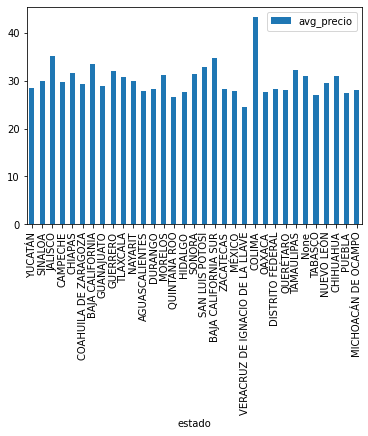

Producto: ARROZ


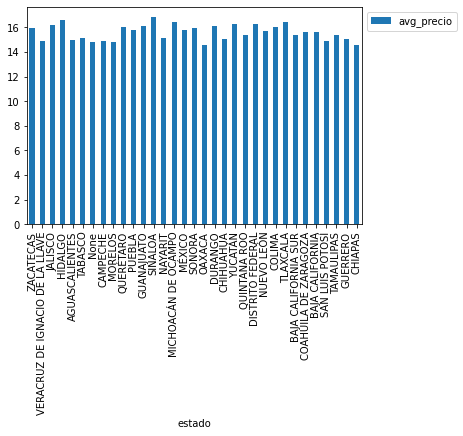

Producto: FRIJOLES


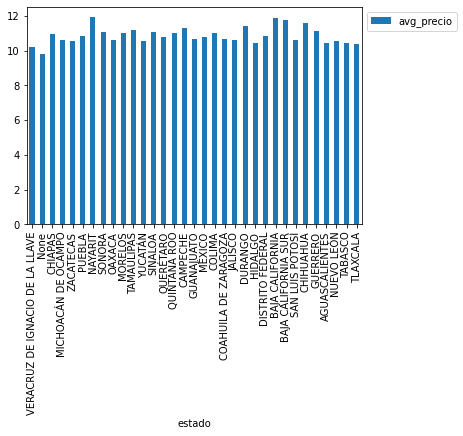

In [137]:
plt.figure(figsize=(12,8))
for producto in pregunta_2.producto.unique():
    print(f'Producto: {producto}')    
    pregunta_1[pregunta_1.producto==producto].plot(x='estado', y='avg_precio',kind='bar')    
    plt.legend(bbox_to_anchor=(1, 1))    
    plt.show()

De esta misma canasta básica compararemos el precio promedio por año

In [139]:
data.agg({"fechaRegistro": "min"}).collect()[0]

Row(min(fechaRegistro)='2011-01-03 00:00:00.000')

In [140]:
data.agg({"fechaRegistro": "max"}).collect()[0]

Row(max(fechaRegistro)='2014-12-26 00:00:00.000')

In [147]:
pregunta_1_2 = (data.filter(data.producto.isin(canasta_basica))
                .select(F.year("fechaRegistro").alias('anio_fecha_registro'), 'producto', 'precio')
                .groupby('producto', 'anio_fecha_registro').agg(F.avg('precio').alias('avg_precio')).toPandas())

Producto: HUEVO


<Figure size 864x576 with 0 Axes>

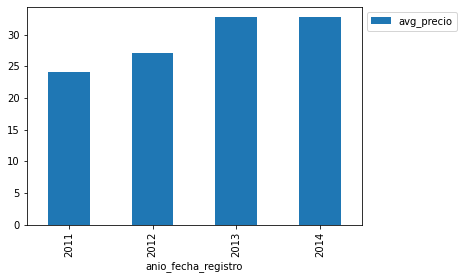

Producto: ARROZ


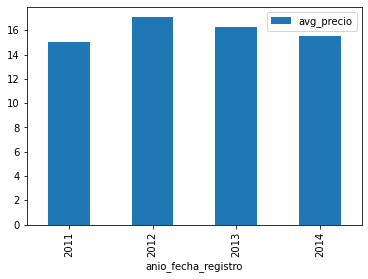

Producto: FRIJOLES


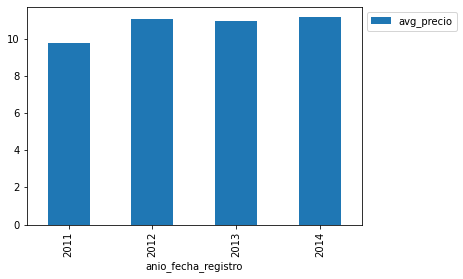

In [148]:
plt.figure(figsize=(12,8))
for producto in pregunta_2_2.producto.unique():
    print(f'Producto: {producto}')    
    pregunta_1_2[pregunta_1_2.producto==producto].sort_values(by='anio_fecha_registro').plot(x='anio_fecha_registro', y='avg_precio',kind='bar')    
    plt.legend(bbox_to_anchor=(1, 1))    
    plt.show()

### ¿Cuál es la ciudad más cara del país? ¿Cuál es la más barata?

Para simplificar esta  respuesta, utilizaremos la misma canasde productos basicos creada en la pregunta anterior. La ciudad más cara del pais sera aquella en la cual la suma del precio promedio de estos 3 productos sea mayor.

Nota: Entiendo que la pregunta dice ciudad, sin embargo ya no me dara tiempo de obtener la ciudad a partir de las coordenadas, por lo que usaré el municipio

In [149]:
pregunta_2 = (data.filter(data.producto.isin(canasta_basica)).groupby('producto', 'municipio')
              .agg(F.avg('precio').alias('avg_precio'))
              .groupby('municipio').agg(F.sum('avg_precio').alias('precio_prom_canasta_basica')).toPandas())

De acuerdo a este análisis el municipio en el que la canasta básica es en promedio más cara es Colima 

In [151]:
pregunta_2[pregunta_2.precio_prom_canasta_basica==pregunta_2.precio_prom_canasta_basica.max()]

,municipio,precio_prom_canasta_basica
79,COLIMA,70.398684


### ¿Hay algún patrón estacional entre años?

In [164]:
pregunta_3 = (data.filter(data.producto.isin(canasta_basica))
                .select(F.month("fechaRegistro").alias('mes_fecha_registro'),
                        F.year("fechaRegistro").alias('anio_fecha_registro'),'producto', 'precio')
                .groupby('producto', 'anio_fecha_registro', 'mes_fecha_registro')
              .agg(F.avg('precio').alias('avg_precio'))
              .groupby('anio_fecha_registro', 'mes_fecha_registro')
              .agg(F.sum('avg_precio').alias('precio_prom_canasta_basica'))
              .toPandas()
             )

/home/meerkat/workspace/virtualenvs/datos_publicos/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


In [231]:
pregunta_3['anio_mes'] = pregunta_3.apply(lambda x: datetime(x['anio_fecha_registro'], x['mes_fecha_registro'], 1),axis=1)

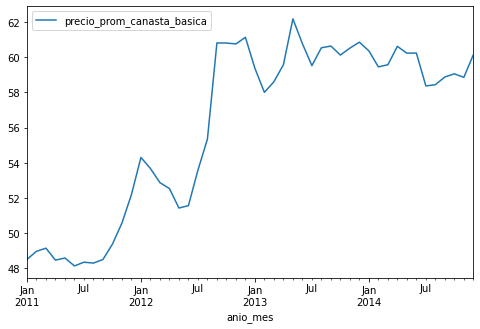

In [233]:
ax = pregunta_3.sort_values('anio_mes').plot(x='anio_mes', y ='precio_prom_canasta_basica',figsize=(8,5))
plt.show()

Para el precio promedio de la canasta básica se observa que de 2011 a 2013 los precios suben entre Julio y Enero y luego de Enero a Julio los precios bajan. Posterior a 2013 no se observa un patrón claro

### ¿Cuál es el estado más caro y en qué mes?

Siguiendo la línea de la canasta básica (:( porque no me dio tiempo de más) anterior determinaremos el estado más caro de acuerdo a los precios de la canasta básica. Primero determinaremos el estado más caro y después analizaremos para que mes es más caro

In [156]:
pregunta_4 = (data.filter(data.producto.isin(canasta_basica)).groupby('producto', 'estado')
              .agg(F.avg('precio').alias('avg_precio'))
              .groupby('estado').agg(F.sum('avg_precio').alias('precio_prom_canasta_basica')).toPandas())

/home/meerkat/workspace/virtualenvs/datos_publicos/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


In [157]:
pregunta_4[pregunta_4.precio_prom_canasta_basica==pregunta_3.precio_prom_canasta_basica.max()]

,estado,precio_prom_canasta_basica
30,COLIMA,70.355355


In [158]:
pregunta_4_2 = (data.filter((data.producto.isin(canasta_basica)) & (data.estado=='COLIMA'))
 .select(F.month("fechaRegistro").alias('mes_fecha_registro'), 'producto', 'precio')
 .groupby('producto', 'mes_fecha_registro')
 .agg(F.avg('precio').alias('avg_precio'))
 .groupby('mes_fecha_registro')
 .agg(F.sum('avg_precio').alias('precio_prom_canasta_basica'))
 .toPandas())

/home/meerkat/workspace/virtualenvs/datos_publicos/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


El estado más caro es Colima en el mes de Mayo

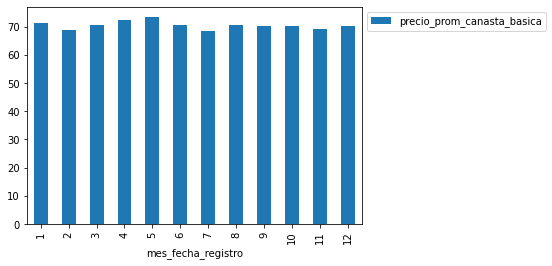

In [163]:
pregunta_4_2.sort_values('mes_fecha_registro').plot(x='mes_fecha_registro', y='precio_prom_canasta_basica', kind='bar')
plt.legend(bbox_to_anchor=(1, 1))

### ¿Cuáles son los principales riesgos de hacer análisis de series de tiempo con estos datos?

De acuerdo a los resultados de la pregunta 2.3 la serie no es homoscedástica y además tiene tendencia creciente pero no es monotona; se ven caídas bastante fuertes. Este tipo de problemas se pueden corregir con técnicas utilizadas para modelar series de tiempo, sin embargo no aseguraría con la información que tengo hasta el momento que esto sería  la mejor opción.